In [1]:
import networkx as nx
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.utils import train_test_split_edges
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns
import xml.etree.ElementTree as ET
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve,average_precision_score
import csv
from torch_geometric.nn import GATConv,VGAE

In [2]:
G = nx.read_graphml("airportsAndCoordAndPop.graphml.xml")

In [3]:
# Charger et analyser le fichier XML
tree = ET.parse('airportsAndCoordAndPop.graphml.xml')
root = tree.getroot()
# Définir l'espace de noms utilisé dans le fichier XML
namespace = {'ns': 'http://graphml.graphdrawing.org/xmlns'}

In [4]:
# Ouvrir un fichier CSV pour écrire les données
with open('data.csv', mode='w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    

    # Écrire l'en-tête du fichier CSV
    csv_writer.writerow(['lon', 'lat', 'population','country','city_name'])
    # Parcourir chaque "record" dans le fichier XML
    for node in root.findall('ns:graph/ns:node', namespace):
        # Trouver les données de chaque nœud
        lon = node.find('ns:data[@key="d0"]', namespace).text
        lat = node.find('ns:data[@key="d1"]', namespace).text
        population = node.find('ns:data[@key="d2"]', namespace).text
        country = node.find('ns:data[@key="d3"]', namespace).text
        city_name = node.find('ns:data[@key="d4"]', namespace).text

        # Écrire les données dans le fichier CSV
        csv_writer.writerow([lon, lat, population, country, city_name])

In [5]:
chemin_fichier = 'data.csv'
dataCSV = pd.read_csv(chemin_fichier)

In [6]:
labelencoder = LabelEncoder()
dataCSV['country'] = labelencoder.fit_transform(dataCSV['country'])
dataCSV['city_name'] = labelencoder.fit_transform(dataCSV['city_name'])

correlation = dataCSV.corr()

In [7]:
print(dataCSV.head(2))

          lon        lat  population  country  city_name
0 -145.509722 -17.353889       10000       66         99
1 -140.950000 -18.066667       10000       66       1071


In [8]:
# Calculer la matrice de corrélation ==> examiner la relation entre les variables
correlation = dataCSV.corr()

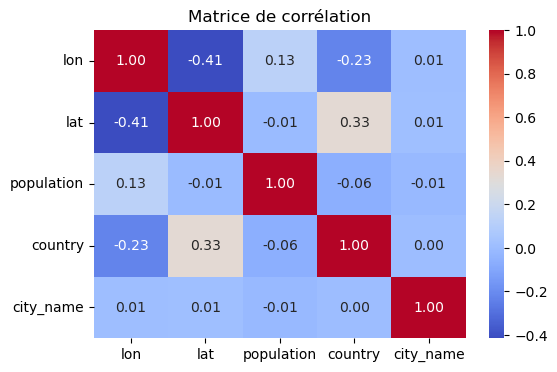

In [9]:
# Tracer la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

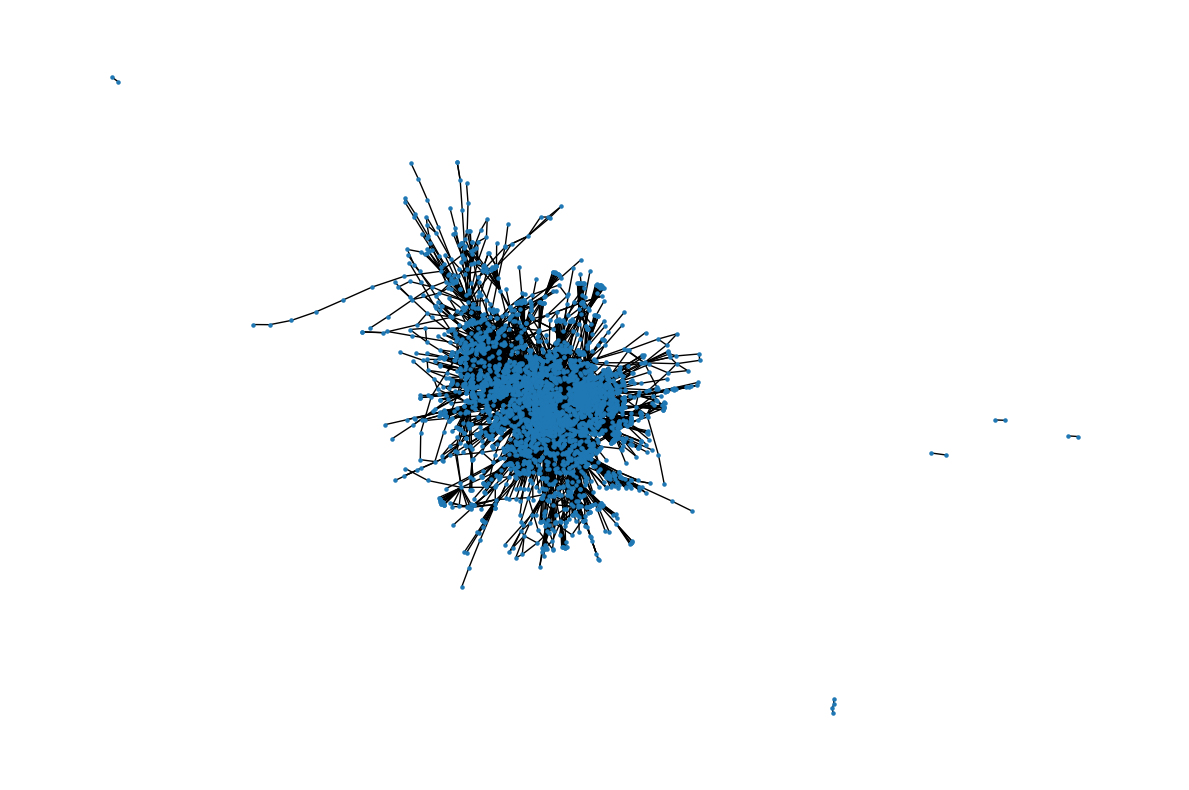

In [10]:
plt.figure(figsize=(12, 8))
nx.draw_networkx(G, with_labels=False, node_size=5)
plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
data = from_networkx(G)

In [4]:
data

Data(edge_index=[2, 27094], lon=[3363], lat=[3363], population=[3363], country=[3363], city_name=[3363], num_nodes=3363)

In [5]:
encoder = LabelEncoder()

country_labels = encoder.fit_transform(data.country)
country_tensor = torch.tensor(country_labels, dtype=torch.long)

city_labels = encoder.fit_transform(data.city_name)
city_tensor = torch.tensor(city_labels, dtype=torch.long)

data.country = country_tensor
data.city_name = city_tensor

In [6]:
features = torch.zeros((data.num_nodes, 5))

In [7]:
features[:, 0] = data['lon']
features[:, 1] = data['lat']
features[:, 2] = data['population']
features[:, 3] = data['country']
features[:, 4] = data['city_name']

In [8]:
data.x = features

In [9]:
data.x

tensor([[-1.4551e+02, -1.7354e+01,  1.0000e+04,  6.6000e+01,  9.9000e+01],
        [-1.4095e+02, -1.8067e+01,  1.0000e+04,  6.6000e+01,  1.0710e+03],
        [-1.4960e+02, -1.7550e+01,  2.6357e+04,  6.6000e+01,  2.2070e+03],
        ...,
        [-1.1320e+02,  5.4743e+01,  1.0000e+04,  3.3000e+01,  3.1990e+03],
        [ 1.4660e+02, -6.1333e+00,  1.0000e+04,  1.4300e+02,  3.2370e+03],
        [ 1.4725e+02, -6.0000e+00,  1.0000e+04,  1.4300e+02,  3.1610e+03]])

In [10]:
scaler = StandardScaler()
x_normalized = scaler.fit_transform(data.x)  
data.x = torch.tensor(x_normalized, dtype=torch.float)

In [11]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0.1,
)
train_data, val_data, test_data = split(data)

In [12]:
def plot_auc_and_loss(loss_values, auc_values):
    loss_values = [i.detach().numpy() for i in loss_values]

    epochs = range(1, len(loss_values) + 1)  # Les numéros d'époques

    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Courbe de Loss
    ax1.plot(epochs, loss_values, label='Training Loss', color='y')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y', labelcolor='y')

    # Second axe Y pour AUC
    ax1_2 = ax1.twinx()  
    ax1_2.plot(epochs, auc_values, label='AUC', color='b')
    ax1_2.set_ylabel('AUC')
    ax1_2.tick_params(axis='y', labelcolor='b')

    ax1.set_title('AUC and Loss Over Epochs')
    ax1.grid(True)

    fig.tight_layout()
    plt.show()

In [13]:
def plot_acc_and_loss(loss_values, acc_values):
    loss_values = [i.detach().numpy() for i in loss_values]

    epochs = range(1, len(loss_values) + 1)  # Les numéros d'époques

    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Courbe de Loss
    ax1.plot(epochs, loss_values, label='Training Loss', color='y')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y', labelcolor='y')

    # Second axe Y pour AUC
    ax1_2 = ax1.twinx()  
    ax1_2.plot(epochs, acc_values, label='AUC', color='b')
    ax1_2.set_ylabel('AUC')
    ax1_2.tick_params(axis='y', labelcolor='b')

    ax1.set_title('ACC and Loss Over Epochs')
    ax1.grid(True)

    fig.tight_layout()
    plt.show()

In [14]:
#Courbe ROC (Receiver Operating Characteristic)
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
#Heatmap de la matrice de confusion
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [24]:
class GCN_1(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_1, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

    

In [25]:
class GCN_2(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,hidden_channels2,hidden_channels3, out_channels):
        super(GCN_2, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, hidden_channels3)
        self.conv4 = GCNConv(hidden_channels3, out_channels)
        self.dropout = nn.Dropout(0.5)
        
    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv3(x, edge_index).relu()
        x = self.dropout(x)
        return self.conv4(x, edge_index)
    
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [26]:
class GCN_3(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,hidden_channels2, out_channels):
        super(GCN_3, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, out_channels)
        self.dropout = nn.Dropout(0.8)
        
    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        x = self.dropout(x)
        return self.conv3(x, edge_index)
    
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [27]:
train_data.edge_label_index

tensor([[ 356,  687,  103,  ...,   65,  103,  117],
        [1057, 1010,  175,  ...,  128,  169,  124]])

In [16]:
@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    AUC = roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())
    ACC = average_precision_score(data.edge_label.cpu().numpy(), out.cpu().numpy())
    return AUC , ACC

In [17]:
def train_link_predictor(model,train_data,val_data):
    loss_val=[]
    y_true=[]
    y_pred=[]
    auc=[]
    acc=[]
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(1, 500 + 1):
        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        neg_edge_index = negative_sampling(edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )

        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)
        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()
        
        val_auc,val_acc = eval_link_predictor(model, val_data)
        
        loss_val.append(loss)
        y_true.append(edge_label)
        y_pred.append(out)
        auc.append(val_auc)
        acc.append(val_acc)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}, Val ACC: {val_acc:.3f}")
    return loss_val,y_true,y_pred,auc,acc

In [30]:
model_1 = GCN_1(5, 128, 2)
model_2 = GCN_2(5, 128,64,32, 2)
model_3 = GCN_3(5, 64,64, 2)

In [25]:
criterion = torch.nn.BCEWithLogitsLoss()

In [32]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_1,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_1, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.515, Val AUC: 0.901, Val ACC: 0.988
Epoch: 020, Train Loss: 0.495, Val AUC: 0.920, Val ACC: 0.991
Epoch: 030, Train Loss: 0.483, Val AUC: 0.922, Val ACC: 0.992
Epoch: 040, Train Loss: 0.475, Val AUC: 0.927, Val ACC: 0.993
Epoch: 050, Train Loss: 0.469, Val AUC: 0.940, Val ACC: 0.994
Epoch: 060, Train Loss: 0.466, Val AUC: 0.941, Val ACC: 0.994
Epoch: 070, Train Loss: 0.465, Val AUC: 0.945, Val ACC: 0.995
Epoch: 080, Train Loss: 0.462, Val AUC: 0.944, Val ACC: 0.994
Epoch: 090, Train Loss: 0.465, Val AUC: 0.941, Val ACC: 0.994
Epoch: 100, Train Loss: 0.463, Val AUC: 0.939, Val ACC: 0.994
Epoch: 110, Train Loss: 0.459, Val AUC: 0.941, Val ACC: 0.994
Epoch: 120, Train Loss: 0.458, Val AUC: 0.942, Val ACC: 0.994
Epoch: 130, Train Loss: 0.459, Val AUC: 0.940, Val ACC: 0.994
Epoch: 140, Train Loss: 0.460, Val AUC: 0.940, Val ACC: 0.994
Epoch: 150, Train Loss: 0.459, Val AUC: 0.938, Val ACC: 0.994
Epoch: 160, Train Loss: 0.460, Val AUC: 0.939, Val ACC: 0.994
Epoch: 1

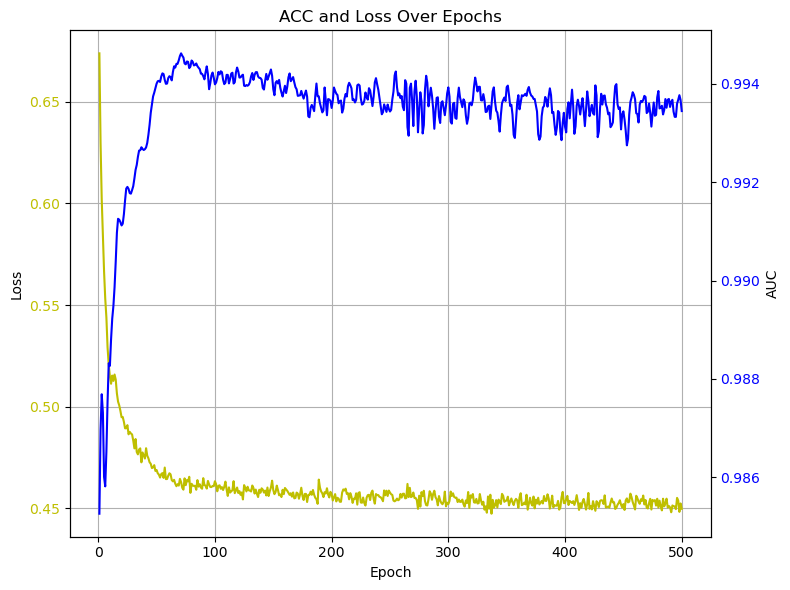

In [33]:
plot_acc_and_loss(loss_val,acc)

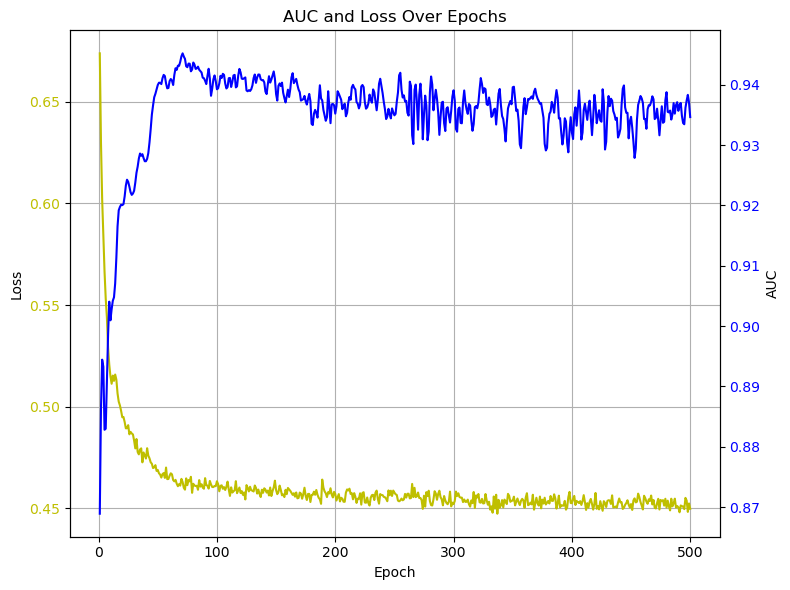

In [34]:
plot_auc_and_loss(loss_val,auc)

In [35]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_2,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_2, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.524, Val AUC: 0.931, Val ACC: 0.993
Epoch: 020, Train Loss: 0.492, Val AUC: 0.938, Val ACC: 0.994
Epoch: 030, Train Loss: 0.478, Val AUC: 0.944, Val ACC: 0.994
Epoch: 040, Train Loss: 0.473, Val AUC: 0.939, Val ACC: 0.994
Epoch: 050, Train Loss: 0.466, Val AUC: 0.934, Val ACC: 0.994
Epoch: 060, Train Loss: 0.471, Val AUC: 0.927, Val ACC: 0.993
Epoch: 070, Train Loss: 0.462, Val AUC: 0.933, Val ACC: 0.993
Epoch: 080, Train Loss: 0.462, Val AUC: 0.931, Val ACC: 0.993
Epoch: 090, Train Loss: 0.459, Val AUC: 0.930, Val ACC: 0.993
Epoch: 100, Train Loss: 0.458, Val AUC: 0.933, Val ACC: 0.993
Epoch: 110, Train Loss: 0.464, Val AUC: 0.935, Val ACC: 0.994
Epoch: 120, Train Loss: 0.456, Val AUC: 0.933, Val ACC: 0.993
Epoch: 130, Train Loss: 0.459, Val AUC: 0.927, Val ACC: 0.993
Epoch: 140, Train Loss: 0.457, Val AUC: 0.935, Val ACC: 0.994
Epoch: 150, Train Loss: 0.463, Val AUC: 0.930, Val ACC: 0.993
Epoch: 160, Train Loss: 0.456, Val AUC: 0.932, Val ACC: 0.993
Epoch: 1

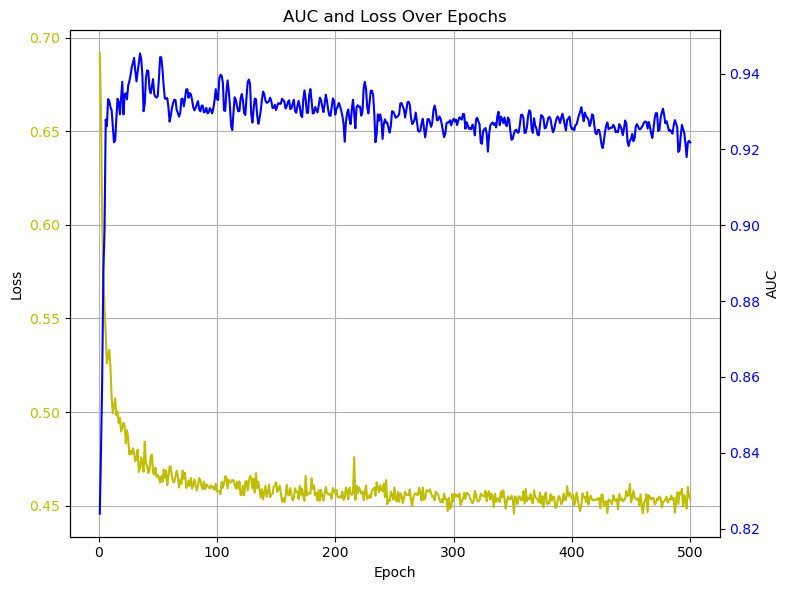

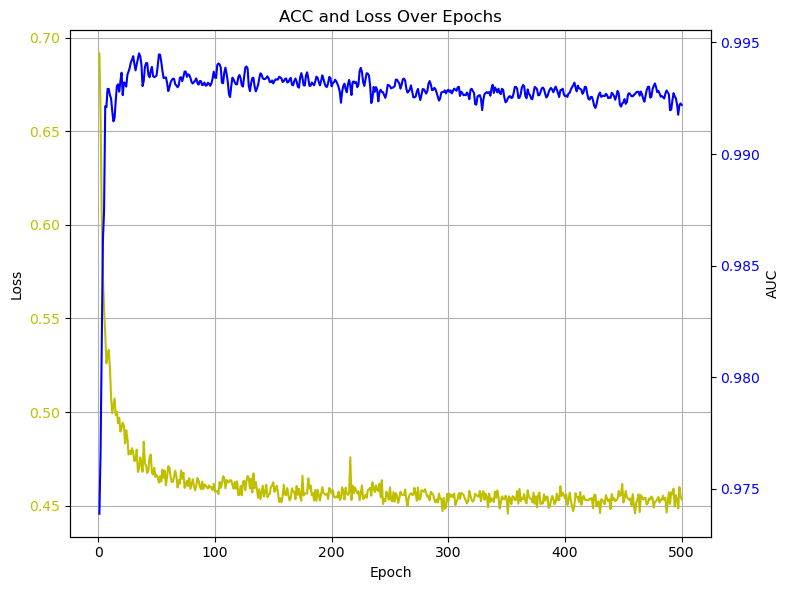

In [36]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [108]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_3,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_3, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.527, Val AUC: 0.880
Epoch: 020, Train Loss: 0.511, Val AUC: 0.907
Epoch: 030, Train Loss: 0.499, Val AUC: 0.911
Epoch: 040, Train Loss: 0.484, Val AUC: 0.924
Epoch: 050, Train Loss: 0.485, Val AUC: 0.923
Epoch: 060, Train Loss: 0.488, Val AUC: 0.926
Epoch: 070, Train Loss: 0.482, Val AUC: 0.926
Epoch: 080, Train Loss: 0.474, Val AUC: 0.928
Epoch: 090, Train Loss: 0.479, Val AUC: 0.927
Epoch: 100, Train Loss: 0.478, Val AUC: 0.926
Epoch: 110, Train Loss: 0.480, Val AUC: 0.928
Epoch: 120, Train Loss: 0.482, Val AUC: 0.928
Epoch: 130, Train Loss: 0.481, Val AUC: 0.923
Epoch: 140, Train Loss: 0.475, Val AUC: 0.927
Epoch: 150, Train Loss: 0.475, Val AUC: 0.929
Epoch: 160, Train Loss: 0.473, Val AUC: 0.930
Epoch: 170, Train Loss: 0.475, Val AUC: 0.931
Epoch: 180, Train Loss: 0.470, Val AUC: 0.932
Epoch: 190, Train Loss: 0.472, Val AUC: 0.929
Epoch: 200, Train Loss: 0.466, Val AUC: 0.932
Epoch: 210, Train Loss: 0.471, Val AUC: 0.928
Epoch: 220, Train Loss: 0.466, Val

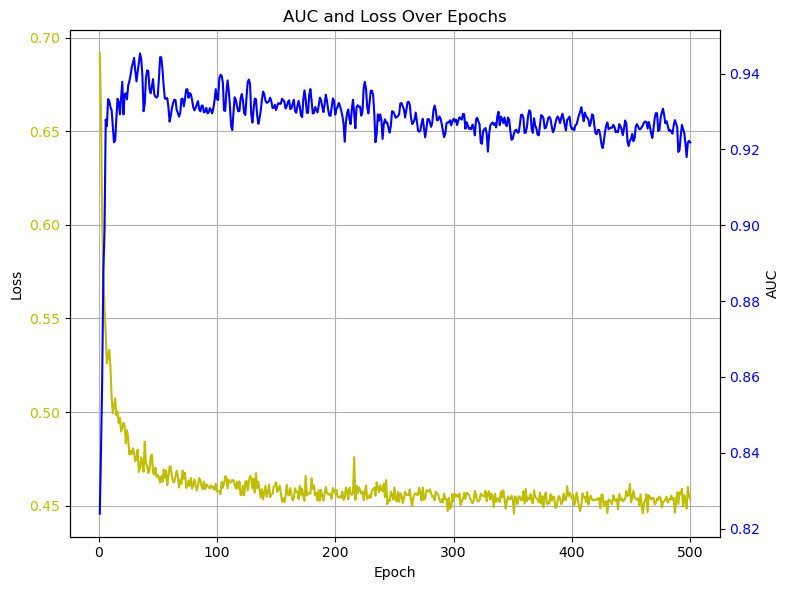

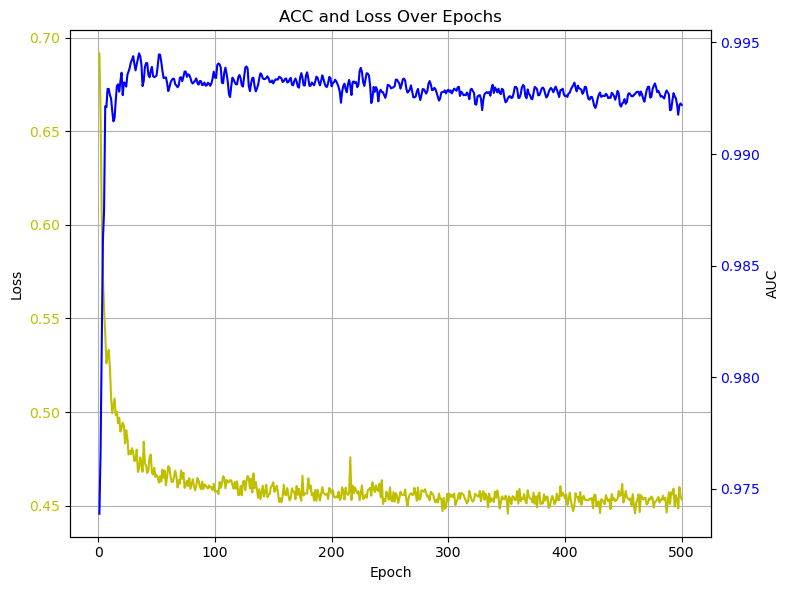

In [37]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [40]:
class GAT_1(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super(GAT_1, self).__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.3)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.3)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        
        return x

    def encode(self, x, edge_index):
        return self.forward(x, edge_index)
    
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
    
    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [41]:
class GAT_2(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,hidden_channels2, out_channels, heads):
        super(GAT_2, self).__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.3)
        self.conv2 = GATConv(hidden_channels*heads, hidden_channels2, heads, dropout=0.3)
        self.conv3 = GATConv(hidden_channels2 * heads, out_channels, heads=1, concat=False, dropout=0.3)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x) 
        x = self.conv3(x, edge_index)
        return x
    
    def encode(self, x, edge_index):
        return self.forward(x, edge_index)
    
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
    
    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [42]:
class GAT_3(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,hidden_channels2,hidden_channels3,out_channels, heads):
        super(GAT_3, self).__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.3)
        self.conv2 = GATConv(hidden_channels*heads, hidden_channels2, heads, dropout=0.3)
        self.conv3 = GATConv(hidden_channels2*heads, hidden_channels3, heads, dropout=0.3)
        self.conv4 = GATConv(hidden_channels3 * heads, out_channels, heads=1, concat=False, dropout=0.3)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x) 
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x) 
        x = self.conv4(x, edge_index)
        
        return x

    def encode(self, x, edge_index):
        return self.forward(x, edge_index)
    
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
    
    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [41]:
model_1 = GAT_1(5, 128, 2,8)
model_2 = GAT_2(5, 64,64, 2,8)
model_3 = GAT_3(5, 128,64,32, 2,8)

In [43]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_1,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_1, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.614, Val AUC: 0.806, Val ACC: 0.966
Epoch: 020, Train Loss: 0.599, Val AUC: 0.860, Val ACC: 0.979
Epoch: 030, Train Loss: 0.586, Val AUC: 0.844, Val ACC: 0.975
Epoch: 040, Train Loss: 0.578, Val AUC: 0.820, Val ACC: 0.972
Epoch: 050, Train Loss: 0.567, Val AUC: 0.829, Val ACC: 0.975
Epoch: 060, Train Loss: 0.561, Val AUC: 0.825, Val ACC: 0.970
Epoch: 070, Train Loss: 0.548, Val AUC: 0.838, Val ACC: 0.976
Epoch: 080, Train Loss: 0.550, Val AUC: 0.844, Val ACC: 0.977
Epoch: 090, Train Loss: 0.542, Val AUC: 0.848, Val ACC: 0.977
Epoch: 100, Train Loss: 0.545, Val AUC: 0.852, Val ACC: 0.978
Epoch: 110, Train Loss: 0.540, Val AUC: 0.842, Val ACC: 0.977
Epoch: 120, Train Loss: 0.542, Val AUC: 0.849, Val ACC: 0.978
Epoch: 130, Train Loss: 0.537, Val AUC: 0.850, Val ACC: 0.977
Epoch: 140, Train Loss: 0.536, Val AUC: 0.859, Val ACC: 0.980
Epoch: 150, Train Loss: 0.537, Val AUC: 0.851, Val ACC: 0.979
Epoch: 160, Train Loss: 0.531, Val AUC: 0.857, Val ACC: 0.980
Epoch: 1

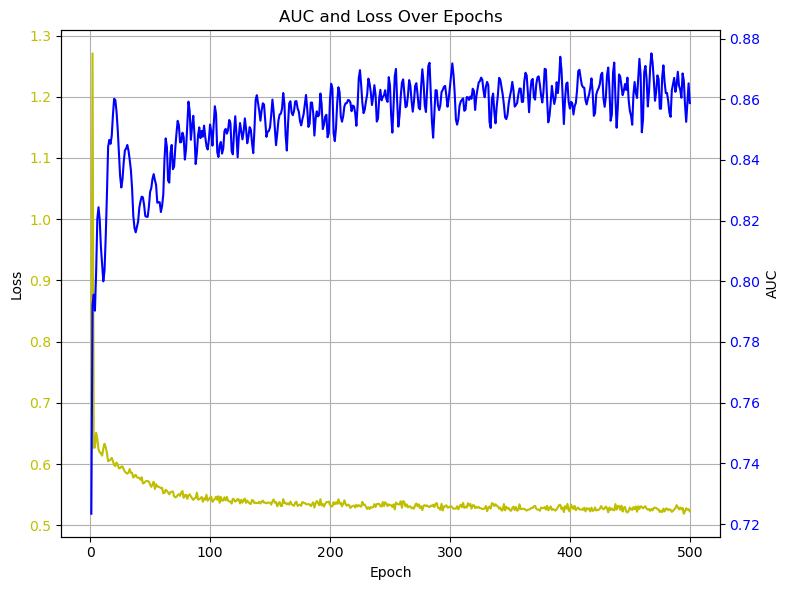

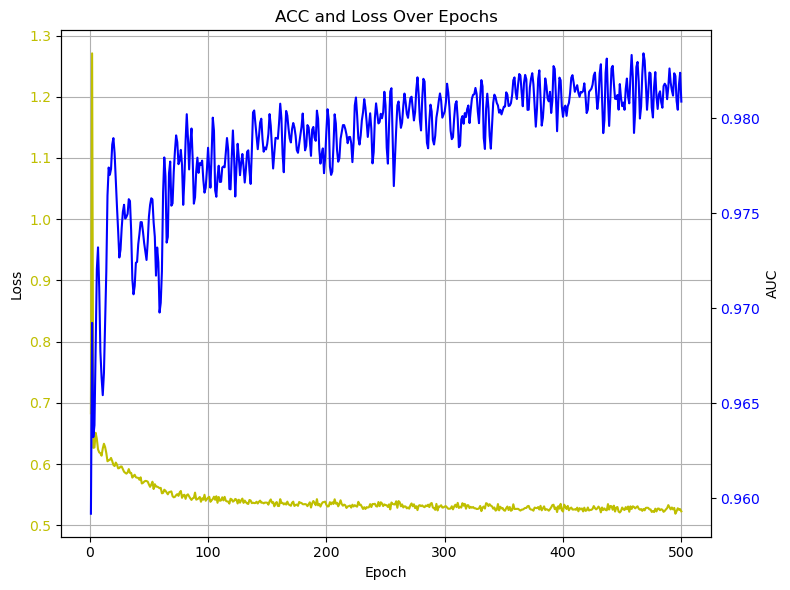

In [44]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [45]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_2,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_2, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 1.000, Val AUC: 0.804, Val ACC: 0.970
Epoch: 020, Train Loss: 0.636, Val AUC: 0.748, Val ACC: 0.958
Epoch: 030, Train Loss: 0.632, Val AUC: 0.785, Val ACC: 0.965
Epoch: 040, Train Loss: 0.596, Val AUC: 0.842, Val ACC: 0.978
Epoch: 050, Train Loss: 0.578, Val AUC: 0.841, Val ACC: 0.974
Epoch: 060, Train Loss: 0.579, Val AUC: 0.839, Val ACC: 0.978
Epoch: 070, Train Loss: 0.575, Val AUC: 0.836, Val ACC: 0.975
Epoch: 080, Train Loss: 0.572, Val AUC: 0.835, Val ACC: 0.976
Epoch: 090, Train Loss: 0.557, Val AUC: 0.839, Val ACC: 0.976
Epoch: 100, Train Loss: 0.561, Val AUC: 0.845, Val ACC: 0.977
Epoch: 110, Train Loss: 0.557, Val AUC: 0.851, Val ACC: 0.979
Epoch: 120, Train Loss: 0.554, Val AUC: 0.849, Val ACC: 0.978
Epoch: 130, Train Loss: 0.546, Val AUC: 0.850, Val ACC: 0.977
Epoch: 140, Train Loss: 0.547, Val AUC: 0.849, Val ACC: 0.979
Epoch: 150, Train Loss: 0.544, Val AUC: 0.852, Val ACC: 0.981
Epoch: 160, Train Loss: 0.532, Val AUC: 0.860, Val ACC: 0.981
Epoch: 1

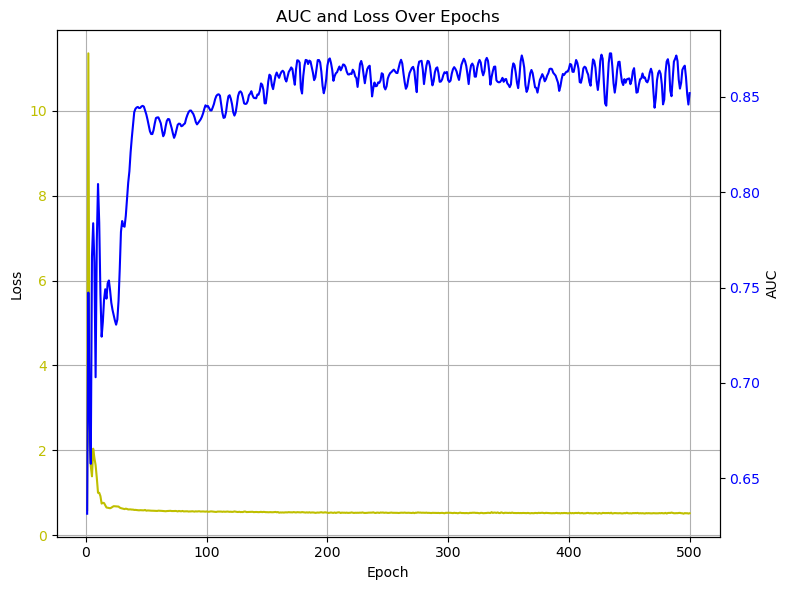

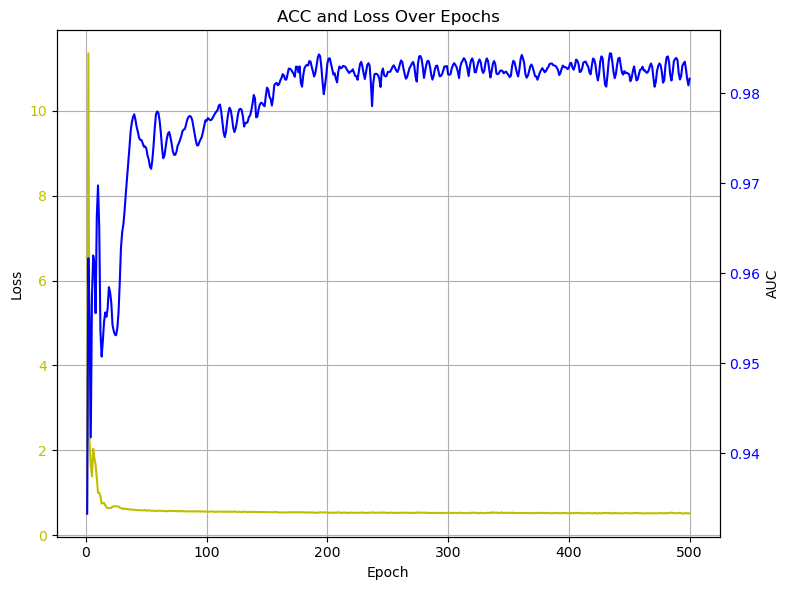

In [46]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [47]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_3,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_3, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 1.411, Val AUC: 0.769, Val ACC: 0.959
Epoch: 020, Train Loss: 1.191, Val AUC: 0.671, Val ACC: 0.933
Epoch: 030, Train Loss: 0.767, Val AUC: 0.730, Val ACC: 0.959
Epoch: 040, Train Loss: 0.676, Val AUC: 0.758, Val ACC: 0.965
Epoch: 050, Train Loss: 0.642, Val AUC: 0.798, Val ACC: 0.972
Epoch: 060, Train Loss: 0.608, Val AUC: 0.824, Val ACC: 0.974
Epoch: 070, Train Loss: 0.587, Val AUC: 0.834, Val ACC: 0.976
Epoch: 080, Train Loss: 0.598, Val AUC: 0.835, Val ACC: 0.977
Epoch: 090, Train Loss: 0.590, Val AUC: 0.840, Val ACC: 0.977
Epoch: 100, Train Loss: 0.582, Val AUC: 0.847, Val ACC: 0.979
Epoch: 110, Train Loss: 0.584, Val AUC: 0.845, Val ACC: 0.979
Epoch: 120, Train Loss: 0.577, Val AUC: 0.841, Val ACC: 0.978
Epoch: 130, Train Loss: 0.571, Val AUC: 0.848, Val ACC: 0.980
Epoch: 140, Train Loss: 0.573, Val AUC: 0.849, Val ACC: 0.980
Epoch: 150, Train Loss: 0.573, Val AUC: 0.851, Val ACC: 0.981
Epoch: 160, Train Loss: 0.572, Val AUC: 0.840, Val ACC: 0.978
Epoch: 1

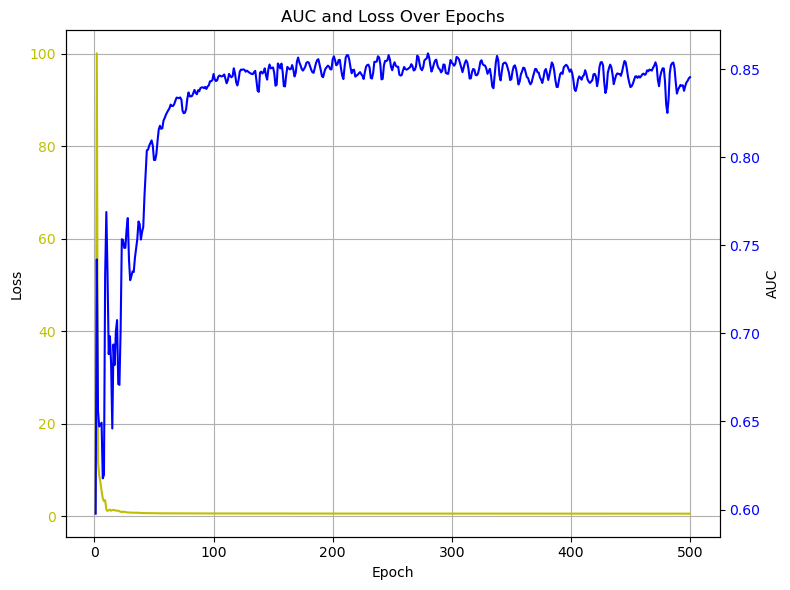

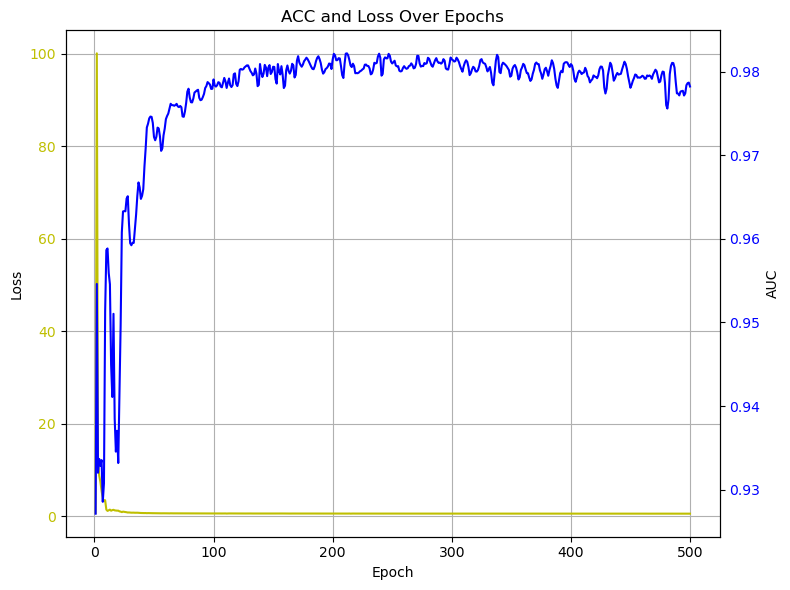

In [48]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [18]:
class Encoder1(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [19]:
class Encoder2(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels,2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [26]:
encoder1 = Encoder1(5, 2)
model1 = VGAE(encoder1)
encoder2 = Encoder2(5, 64, 2 )
model2 = VGAE(encoder2)

In [29]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model1,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model1, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.631, Val AUC: 0.836, Val ACC: 0.972
Epoch: 020, Train Loss: 0.632, Val AUC: 0.836, Val ACC: 0.972
Epoch: 030, Train Loss: 0.632, Val AUC: 0.838, Val ACC: 0.972
Epoch: 040, Train Loss: 0.629, Val AUC: 0.837, Val ACC: 0.972
Epoch: 050, Train Loss: 0.631, Val AUC: 0.837, Val ACC: 0.972
Epoch: 060, Train Loss: 0.635, Val AUC: 0.838, Val ACC: 0.972
Epoch: 070, Train Loss: 0.630, Val AUC: 0.838, Val ACC: 0.972
Epoch: 080, Train Loss: 0.628, Val AUC: 0.838, Val ACC: 0.972
Epoch: 090, Train Loss: 0.632, Val AUC: 0.837, Val ACC: 0.972
Epoch: 100, Train Loss: 0.629, Val AUC: 0.838, Val ACC: 0.972
Epoch: 110, Train Loss: 0.630, Val AUC: 0.839, Val ACC: 0.972
Epoch: 120, Train Loss: 0.631, Val AUC: 0.838, Val ACC: 0.972
Epoch: 130, Train Loss: 0.632, Val AUC: 0.838, Val ACC: 0.972
Epoch: 140, Train Loss: 0.630, Val AUC: 0.838, Val ACC: 0.972
Epoch: 150, Train Loss: 0.631, Val AUC: 0.839, Val ACC: 0.972
Epoch: 160, Train Loss: 0.629, Val AUC: 0.839, Val ACC: 0.972
Epoch: 1

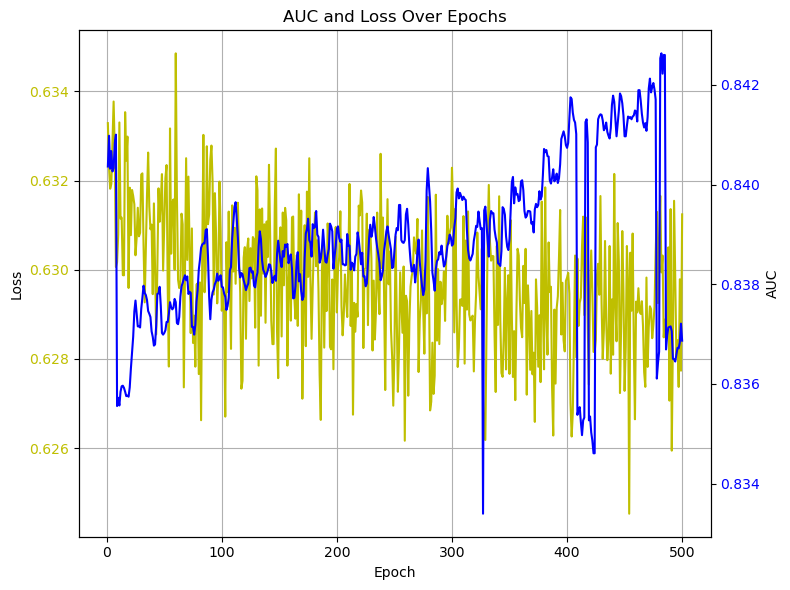

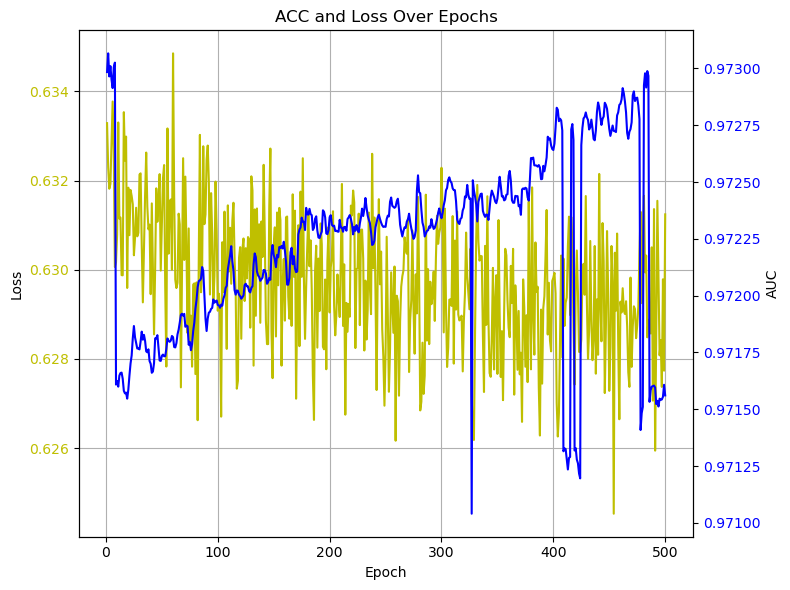

In [30]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [31]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model2,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model2, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.694, Val AUC: 0.818, Val ACC: 0.978
Epoch: 020, Train Loss: 0.679, Val AUC: 0.817, Val ACC: 0.979
Epoch: 030, Train Loss: 0.665, Val AUC: 0.803, Val ACC: 0.974
Epoch: 040, Train Loss: 0.667, Val AUC: 0.803, Val ACC: 0.974
Epoch: 050, Train Loss: 0.661, Val AUC: 0.797, Val ACC: 0.972
Epoch: 060, Train Loss: 0.655, Val AUC: 0.792, Val ACC: 0.970
Epoch: 070, Train Loss: 0.655, Val AUC: 0.803, Val ACC: 0.973
Epoch: 080, Train Loss: 0.653, Val AUC: 0.798, Val ACC: 0.970
Epoch: 090, Train Loss: 0.654, Val AUC: 0.797, Val ACC: 0.969
Epoch: 100, Train Loss: 0.650, Val AUC: 0.801, Val ACC: 0.969
Epoch: 110, Train Loss: 0.648, Val AUC: 0.808, Val ACC: 0.970
Epoch: 120, Train Loss: 0.646, Val AUC: 0.822, Val ACC: 0.971
Epoch: 130, Train Loss: 0.642, Val AUC: 0.826, Val ACC: 0.972
Epoch: 140, Train Loss: 0.638, Val AUC: 0.828, Val ACC: 0.972
Epoch: 150, Train Loss: 0.635, Val AUC: 0.823, Val ACC: 0.970
Epoch: 160, Train Loss: 0.630, Val AUC: 0.845, Val ACC: 0.974
Epoch: 1

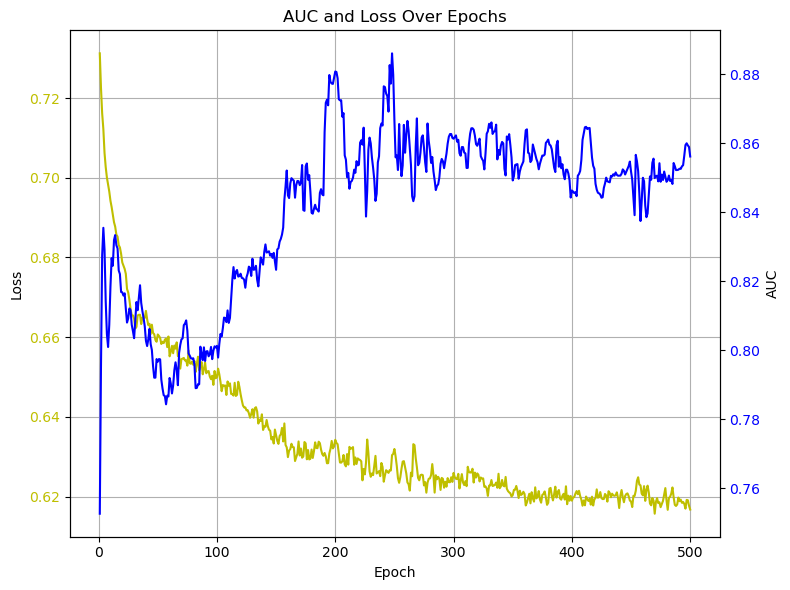

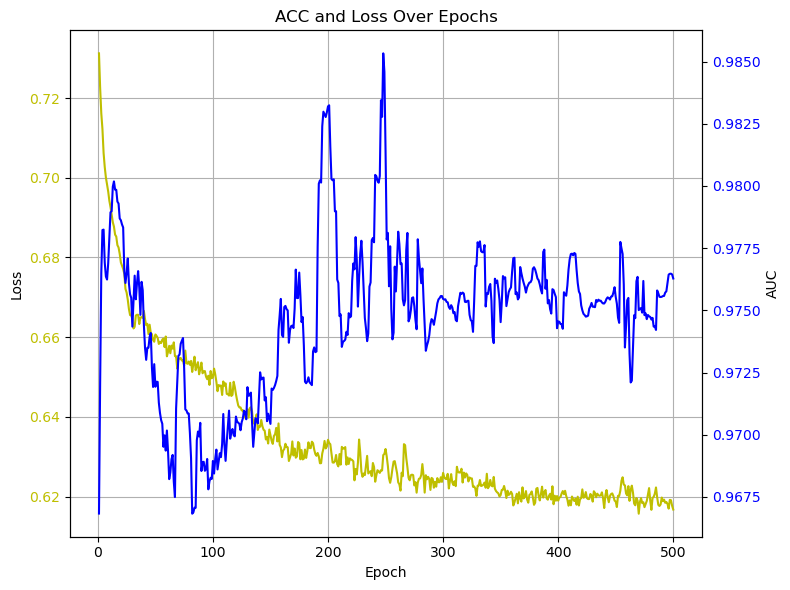

In [32]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [51]:
split2 = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.2,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0.1,
)
train_data, val_data, test_data = split2(data)

In [53]:
model_1 = GCN_1(5, 128, 2)
model_2 = GCN_2(5, 128,64,32, 2)
model_3 = GCN_3(5, 64,64, 2)

In [54]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_1,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_1, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.532, Val AUC: 0.854, Val ACC: 0.983
Epoch: 020, Train Loss: 0.509, Val AUC: 0.876, Val ACC: 0.986
Epoch: 030, Train Loss: 0.483, Val AUC: 0.892, Val ACC: 0.988
Epoch: 040, Train Loss: 0.474, Val AUC: 0.902, Val ACC: 0.989
Epoch: 050, Train Loss: 0.470, Val AUC: 0.894, Val ACC: 0.988
Epoch: 060, Train Loss: 0.468, Val AUC: 0.892, Val ACC: 0.988
Epoch: 070, Train Loss: 0.464, Val AUC: 0.899, Val ACC: 0.989
Epoch: 080, Train Loss: 0.465, Val AUC: 0.895, Val ACC: 0.988
Epoch: 090, Train Loss: 0.461, Val AUC: 0.900, Val ACC: 0.989
Epoch: 100, Train Loss: 0.464, Val AUC: 0.900, Val ACC: 0.989
Epoch: 110, Train Loss: 0.463, Val AUC: 0.904, Val ACC: 0.990
Epoch: 120, Train Loss: 0.459, Val AUC: 0.902, Val ACC: 0.989
Epoch: 130, Train Loss: 0.458, Val AUC: 0.904, Val ACC: 0.989
Epoch: 140, Train Loss: 0.456, Val AUC: 0.902, Val ACC: 0.989
Epoch: 150, Train Loss: 0.456, Val AUC: 0.904, Val ACC: 0.989
Epoch: 160, Train Loss: 0.458, Val AUC: 0.906, Val ACC: 0.990
Epoch: 1

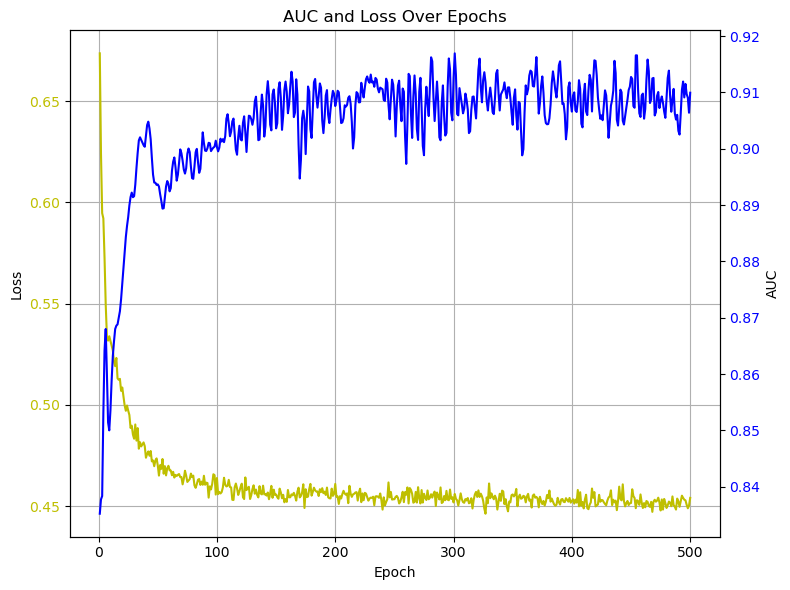

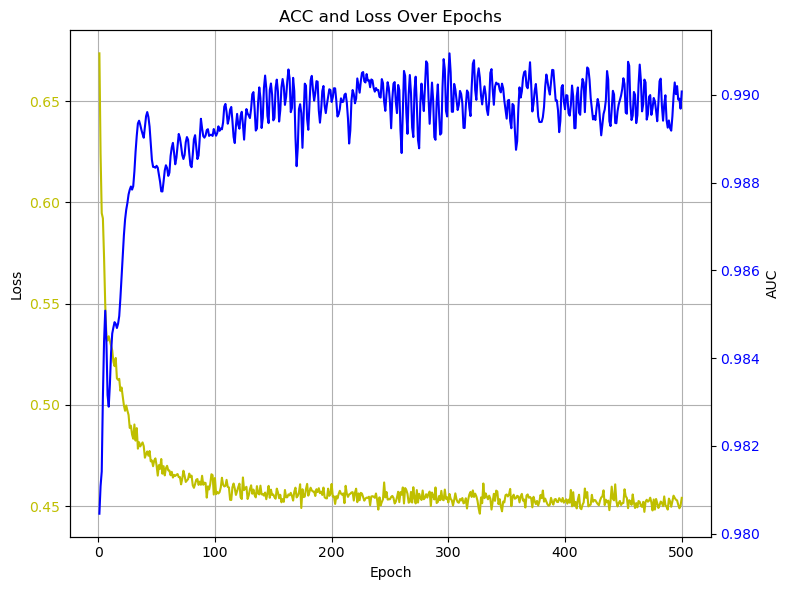

In [55]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [56]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_2,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_2, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.557, Val AUC: 0.874, Val ACC: 0.984
Epoch: 020, Train Loss: 0.519, Val AUC: 0.885, Val ACC: 0.988
Epoch: 030, Train Loss: 0.483, Val AUC: 0.898, Val ACC: 0.989
Epoch: 040, Train Loss: 0.473, Val AUC: 0.904, Val ACC: 0.989
Epoch: 050, Train Loss: 0.470, Val AUC: 0.905, Val ACC: 0.990
Epoch: 060, Train Loss: 0.466, Val AUC: 0.903, Val ACC: 0.989
Epoch: 070, Train Loss: 0.473, Val AUC: 0.895, Val ACC: 0.989
Epoch: 080, Train Loss: 0.464, Val AUC: 0.904, Val ACC: 0.989
Epoch: 090, Train Loss: 0.463, Val AUC: 0.904, Val ACC: 0.990
Epoch: 100, Train Loss: 0.466, Val AUC: 0.904, Val ACC: 0.989
Epoch: 110, Train Loss: 0.459, Val AUC: 0.896, Val ACC: 0.989
Epoch: 120, Train Loss: 0.459, Val AUC: 0.901, Val ACC: 0.989
Epoch: 130, Train Loss: 0.460, Val AUC: 0.896, Val ACC: 0.988
Epoch: 140, Train Loss: 0.460, Val AUC: 0.893, Val ACC: 0.988
Epoch: 150, Train Loss: 0.460, Val AUC: 0.902, Val ACC: 0.989
Epoch: 160, Train Loss: 0.461, Val AUC: 0.898, Val ACC: 0.989
Epoch: 1

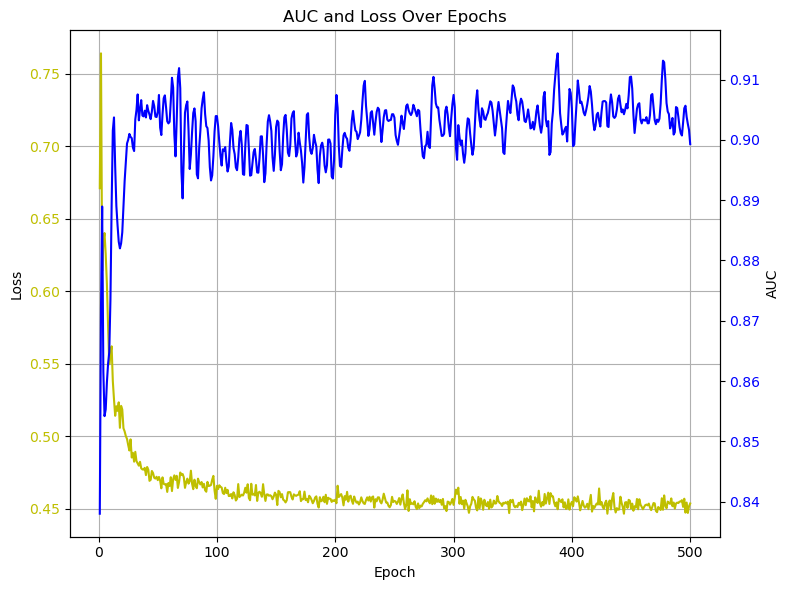

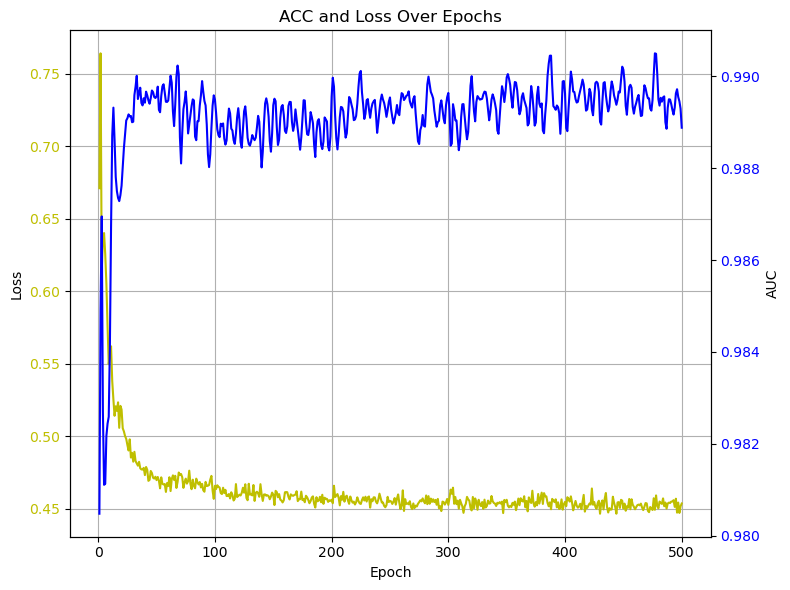

In [57]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [58]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_3,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_3, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.533, Val AUC: 0.903, Val ACC: 0.989
Epoch: 020, Train Loss: 0.511, Val AUC: 0.906, Val ACC: 0.990
Epoch: 030, Train Loss: 0.493, Val AUC: 0.902, Val ACC: 0.989
Epoch: 040, Train Loss: 0.484, Val AUC: 0.907, Val ACC: 0.990
Epoch: 050, Train Loss: 0.480, Val AUC: 0.908, Val ACC: 0.990
Epoch: 060, Train Loss: 0.479, Val AUC: 0.903, Val ACC: 0.989
Epoch: 070, Train Loss: 0.478, Val AUC: 0.907, Val ACC: 0.990
Epoch: 080, Train Loss: 0.484, Val AUC: 0.903, Val ACC: 0.989
Epoch: 090, Train Loss: 0.478, Val AUC: 0.900, Val ACC: 0.989
Epoch: 100, Train Loss: 0.490, Val AUC: 0.904, Val ACC: 0.989
Epoch: 110, Train Loss: 0.480, Val AUC: 0.905, Val ACC: 0.990
Epoch: 120, Train Loss: 0.469, Val AUC: 0.907, Val ACC: 0.990
Epoch: 130, Train Loss: 0.478, Val AUC: 0.902, Val ACC: 0.989
Epoch: 140, Train Loss: 0.474, Val AUC: 0.898, Val ACC: 0.989
Epoch: 150, Train Loss: 0.474, Val AUC: 0.906, Val ACC: 0.990
Epoch: 160, Train Loss: 0.475, Val AUC: 0.902, Val ACC: 0.989
Epoch: 1

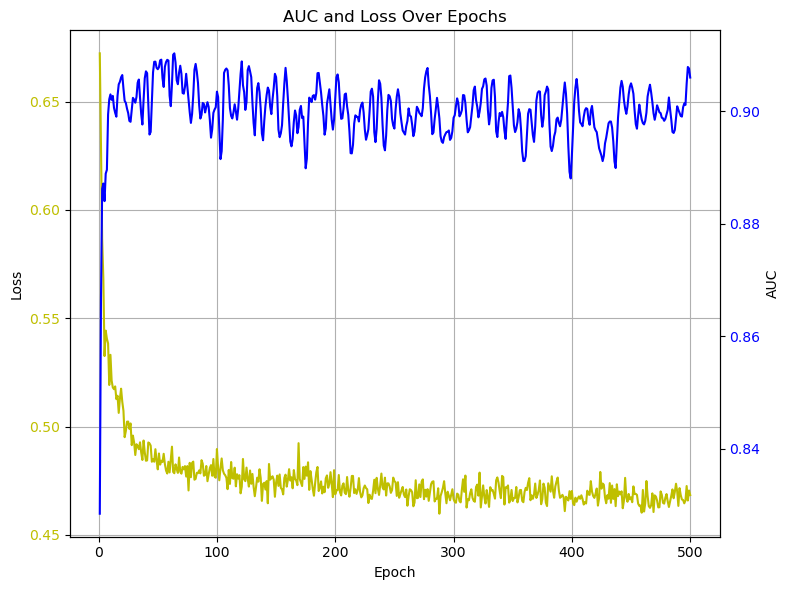

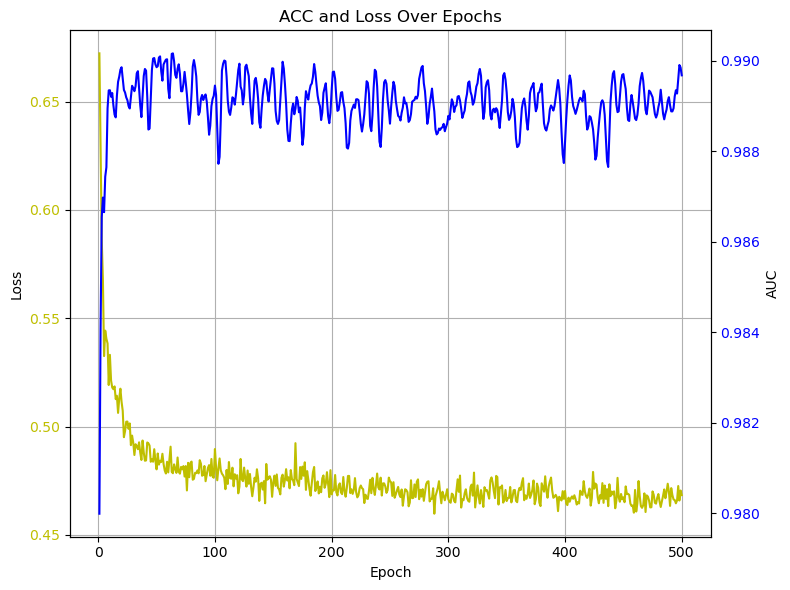

In [59]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [33]:
encoder1 = Encoder1(5, 2)
model1 = VGAE(encoder1)
encoder2 = Encoder2(5, 64, 2 )
model2 = VGAE(encoder2)

In [34]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model1,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model1, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.705, Val AUC: 0.866, Val ACC: 0.982
Epoch: 020, Train Loss: 0.686, Val AUC: 0.870, Val ACC: 0.983
Epoch: 030, Train Loss: 0.677, Val AUC: 0.873, Val ACC: 0.984
Epoch: 040, Train Loss: 0.675, Val AUC: 0.875, Val ACC: 0.985
Epoch: 050, Train Loss: 0.671, Val AUC: 0.879, Val ACC: 0.985
Epoch: 060, Train Loss: 0.667, Val AUC: 0.885, Val ACC: 0.986
Epoch: 070, Train Loss: 0.664, Val AUC: 0.893, Val ACC: 0.987
Epoch: 080, Train Loss: 0.661, Val AUC: 0.894, Val ACC: 0.987
Epoch: 090, Train Loss: 0.659, Val AUC: 0.895, Val ACC: 0.987
Epoch: 100, Train Loss: 0.656, Val AUC: 0.895, Val ACC: 0.987
Epoch: 110, Train Loss: 0.655, Val AUC: 0.893, Val ACC: 0.986
Epoch: 120, Train Loss: 0.654, Val AUC: 0.895, Val ACC: 0.986
Epoch: 130, Train Loss: 0.650, Val AUC: 0.894, Val ACC: 0.986
Epoch: 140, Train Loss: 0.647, Val AUC: 0.894, Val ACC: 0.986
Epoch: 150, Train Loss: 0.647, Val AUC: 0.895, Val ACC: 0.986
Epoch: 160, Train Loss: 0.644, Val AUC: 0.891, Val ACC: 0.983
Epoch: 1

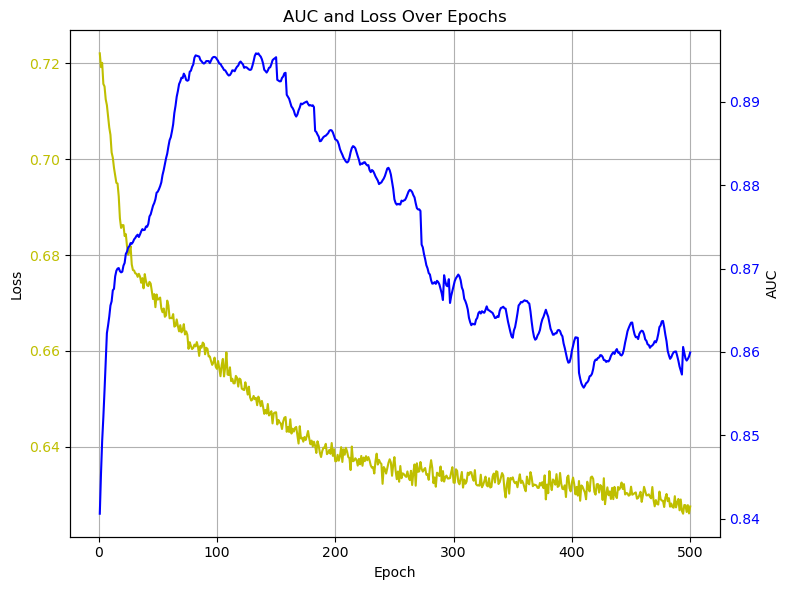

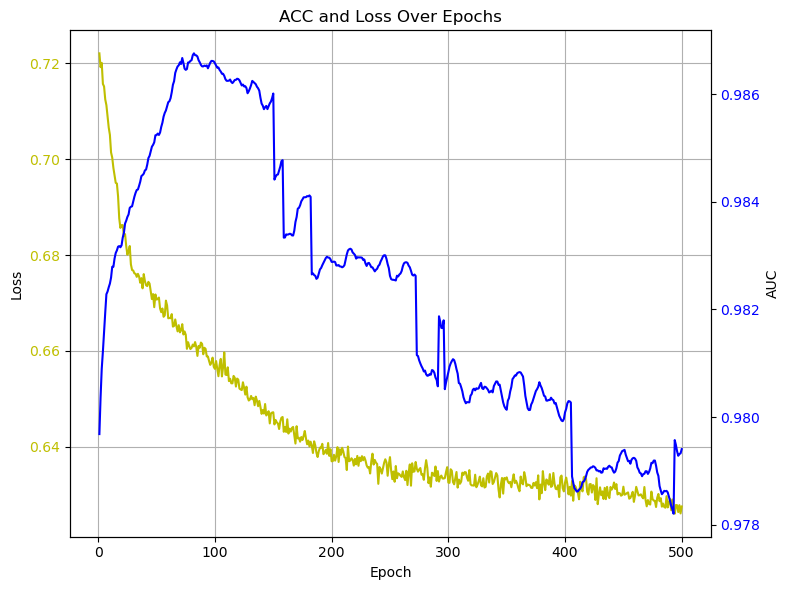

In [35]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [36]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model2,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model2, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.683, Val AUC: 0.825, Val ACC: 0.978
Epoch: 020, Train Loss: 0.668, Val AUC: 0.812, Val ACC: 0.971
Epoch: 030, Train Loss: 0.668, Val AUC: 0.823, Val ACC: 0.974
Epoch: 040, Train Loss: 0.664, Val AUC: 0.812, Val ACC: 0.972
Epoch: 050, Train Loss: 0.660, Val AUC: 0.837, Val ACC: 0.976
Epoch: 060, Train Loss: 0.658, Val AUC: 0.831, Val ACC: 0.973
Epoch: 070, Train Loss: 0.659, Val AUC: 0.860, Val ACC: 0.979
Epoch: 080, Train Loss: 0.655, Val AUC: 0.854, Val ACC: 0.976
Epoch: 090, Train Loss: 0.654, Val AUC: 0.830, Val ACC: 0.971
Epoch: 100, Train Loss: 0.650, Val AUC: 0.844, Val ACC: 0.973
Epoch: 110, Train Loss: 0.649, Val AUC: 0.838, Val ACC: 0.972
Epoch: 120, Train Loss: 0.647, Val AUC: 0.845, Val ACC: 0.973
Epoch: 130, Train Loss: 0.646, Val AUC: 0.845, Val ACC: 0.973
Epoch: 140, Train Loss: 0.644, Val AUC: 0.841, Val ACC: 0.973
Epoch: 150, Train Loss: 0.642, Val AUC: 0.842, Val ACC: 0.973
Epoch: 160, Train Loss: 0.643, Val AUC: 0.843, Val ACC: 0.974
Epoch: 1

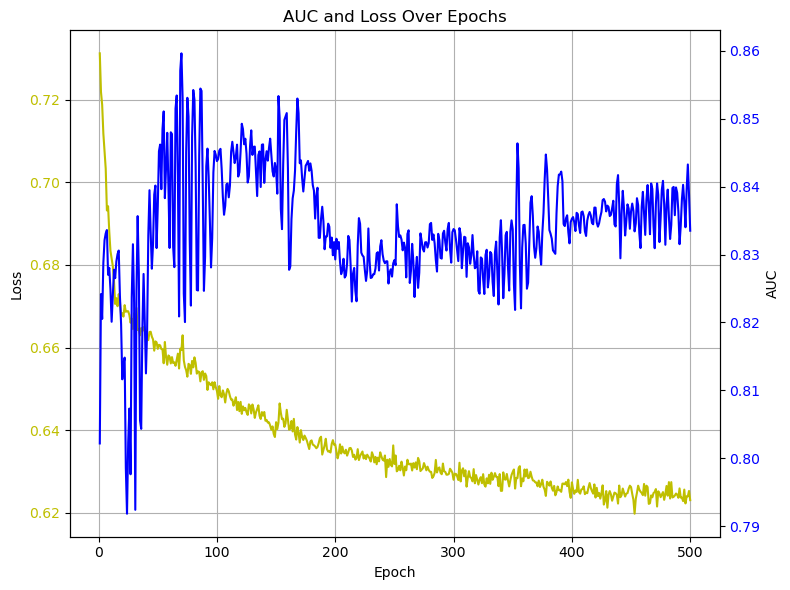

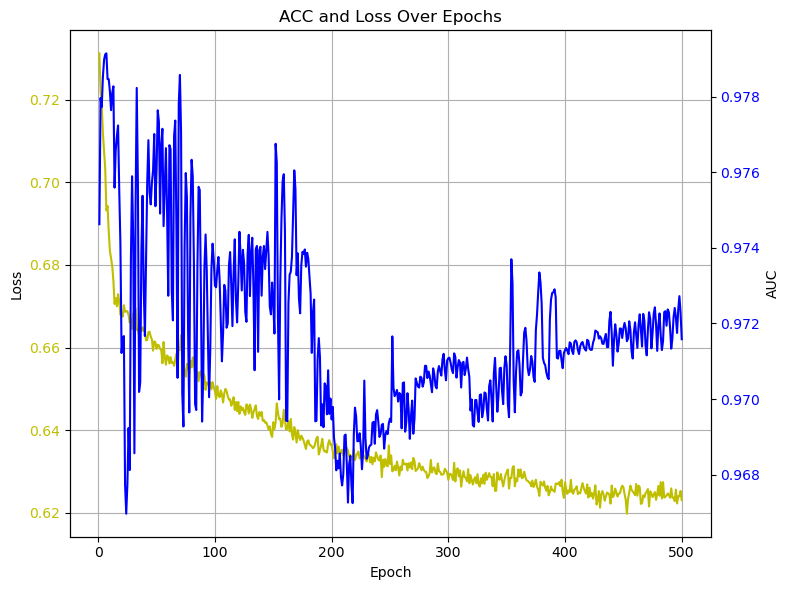

In [37]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [43]:
model_1 = GAT_1(5, 128, 2,8)
model_2 = GAT_2(5, 64,64, 2,8)
model_3 = GAT_3(5, 128,64,32, 2,8)

In [44]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_1,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_1, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 0.596, Val AUC: 0.821, Val ACC: 0.969
Epoch: 020, Train Loss: 0.593, Val AUC: 0.817, Val ACC: 0.967
Epoch: 030, Train Loss: 0.584, Val AUC: 0.834, Val ACC: 0.973
Epoch: 040, Train Loss: 0.575, Val AUC: 0.826, Val ACC: 0.971
Epoch: 050, Train Loss: 0.560, Val AUC: 0.850, Val ACC: 0.977
Epoch: 060, Train Loss: 0.549, Val AUC: 0.867, Val ACC: 0.981
Epoch: 070, Train Loss: 0.549, Val AUC: 0.855, Val ACC: 0.979
Epoch: 080, Train Loss: 0.544, Val AUC: 0.864, Val ACC: 0.980
Epoch: 090, Train Loss: 0.537, Val AUC: 0.871, Val ACC: 0.981
Epoch: 100, Train Loss: 0.537, Val AUC: 0.875, Val ACC: 0.983
Epoch: 110, Train Loss: 0.535, Val AUC: 0.873, Val ACC: 0.982
Epoch: 120, Train Loss: 0.537, Val AUC: 0.874, Val ACC: 0.982
Epoch: 130, Train Loss: 0.532, Val AUC: 0.858, Val ACC: 0.981
Epoch: 140, Train Loss: 0.529, Val AUC: 0.865, Val ACC: 0.982
Epoch: 150, Train Loss: 0.534, Val AUC: 0.875, Val ACC: 0.983
Epoch: 160, Train Loss: 0.532, Val AUC: 0.861, Val ACC: 0.980
Epoch: 1

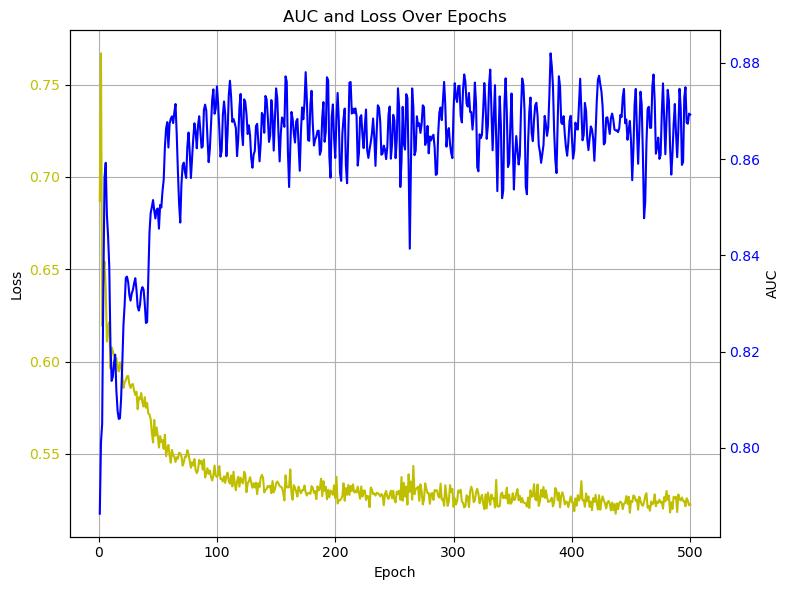

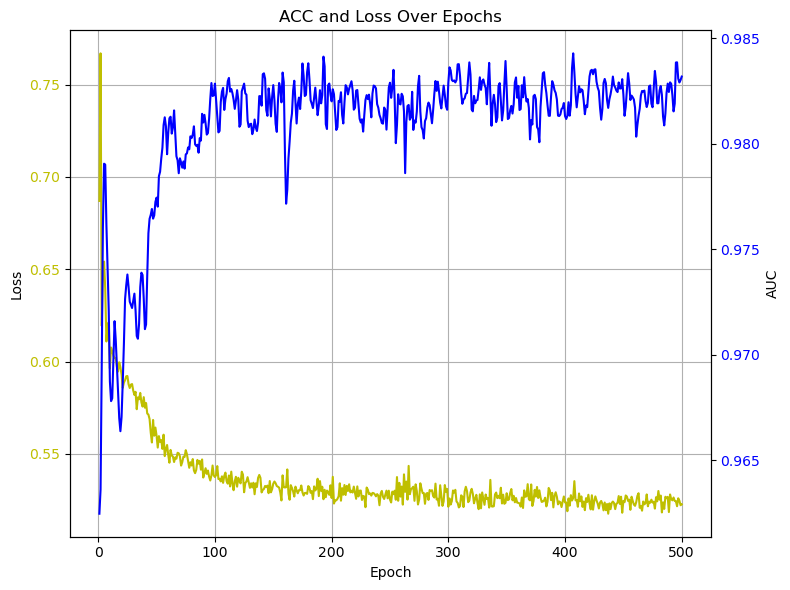

In [45]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [46]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_2,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_2, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 1.414, Val AUC: 0.609, Val ACC: 0.936
Epoch: 020, Train Loss: 0.684, Val AUC: 0.645, Val ACC: 0.946
Epoch: 030, Train Loss: 0.732, Val AUC: 0.707, Val ACC: 0.952
Epoch: 040, Train Loss: 0.640, Val AUC: 0.843, Val ACC: 0.974
Epoch: 050, Train Loss: 0.600, Val AUC: 0.825, Val ACC: 0.970
Epoch: 060, Train Loss: 0.600, Val AUC: 0.823, Val ACC: 0.970
Epoch: 070, Train Loss: 0.587, Val AUC: 0.828, Val ACC: 0.972
Epoch: 080, Train Loss: 0.581, Val AUC: 0.830, Val ACC: 0.972
Epoch: 090, Train Loss: 0.576, Val AUC: 0.827, Val ACC: 0.972
Epoch: 100, Train Loss: 0.568, Val AUC: 0.832, Val ACC: 0.973
Epoch: 110, Train Loss: 0.568, Val AUC: 0.838, Val ACC: 0.975
Epoch: 120, Train Loss: 0.570, Val AUC: 0.848, Val ACC: 0.977
Epoch: 130, Train Loss: 0.568, Val AUC: 0.849, Val ACC: 0.977
Epoch: 140, Train Loss: 0.564, Val AUC: 0.852, Val ACC: 0.978
Epoch: 150, Train Loss: 0.554, Val AUC: 0.859, Val ACC: 0.980
Epoch: 160, Train Loss: 0.559, Val AUC: 0.858, Val ACC: 0.980
Epoch: 1

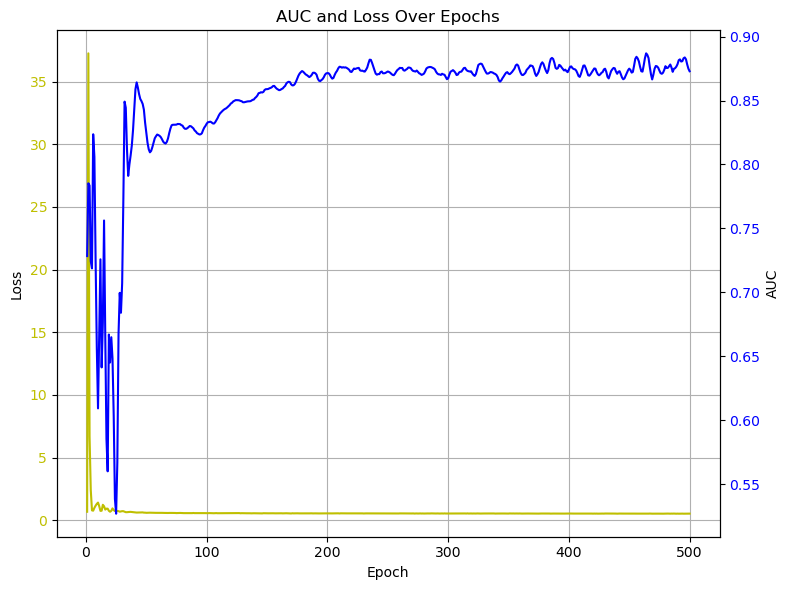

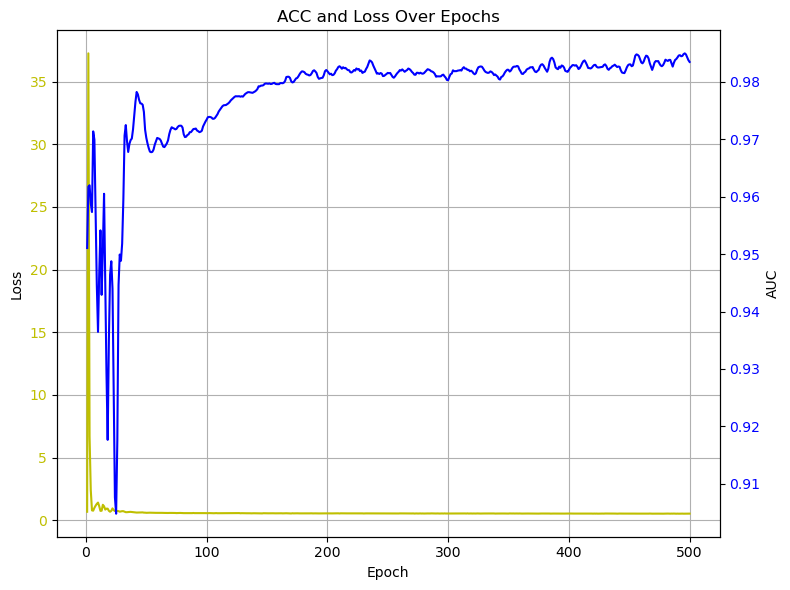

In [47]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)

In [48]:
loss_val,y_true,y_pred,auc,acc=train_link_predictor(model_3,train_data,val_data)
test_auc,test_acc = eval_link_predictor(model_3, test_data)
print(f"======> Test AUC : {test_auc:.3f}")
print(f"======> Test ACC : {test_acc:.3f}")

Epoch: 010, Train Loss: 2.881, Val AUC: 0.756, Val ACC: 0.960
Epoch: 020, Train Loss: 1.612, Val AUC: 0.736, Val ACC: 0.952
Epoch: 030, Train Loss: 0.900, Val AUC: 0.710, Val ACC: 0.954
Epoch: 040, Train Loss: 0.686, Val AUC: 0.681, Val ACC: 0.946
Epoch: 050, Train Loss: 0.642, Val AUC: 0.810, Val ACC: 0.969
Epoch: 060, Train Loss: 0.616, Val AUC: 0.848, Val ACC: 0.976
Epoch: 070, Train Loss: 0.598, Val AUC: 0.827, Val ACC: 0.970
Epoch: 080, Train Loss: 0.601, Val AUC: 0.807, Val ACC: 0.967
Epoch: 090, Train Loss: 0.587, Val AUC: 0.817, Val ACC: 0.970
Epoch: 100, Train Loss: 0.591, Val AUC: 0.832, Val ACC: 0.971
Epoch: 110, Train Loss: 0.585, Val AUC: 0.835, Val ACC: 0.974
Epoch: 120, Train Loss: 0.586, Val AUC: 0.845, Val ACC: 0.974
Epoch: 130, Train Loss: 0.584, Val AUC: 0.842, Val ACC: 0.971
Epoch: 140, Train Loss: 0.575, Val AUC: 0.843, Val ACC: 0.973
Epoch: 150, Train Loss: 0.572, Val AUC: 0.850, Val ACC: 0.977
Epoch: 160, Train Loss: 0.573, Val AUC: 0.837, Val ACC: 0.976
Epoch: 1

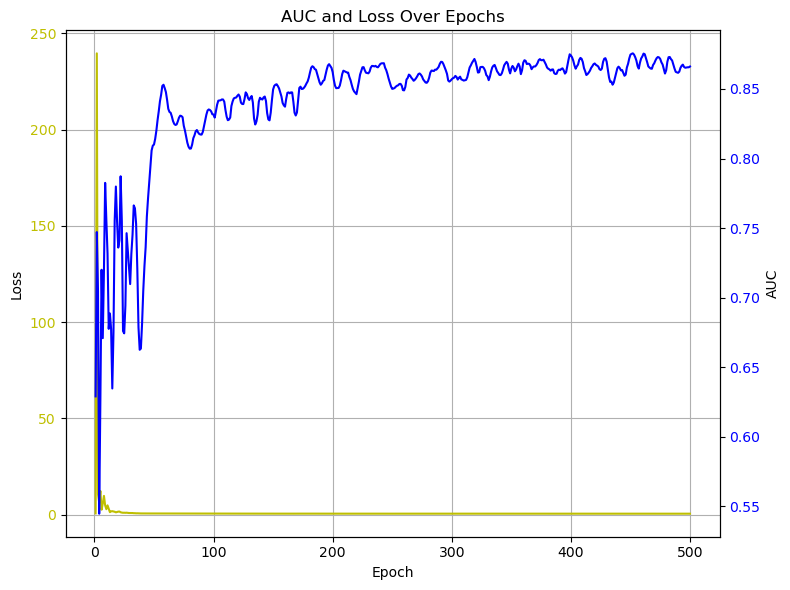

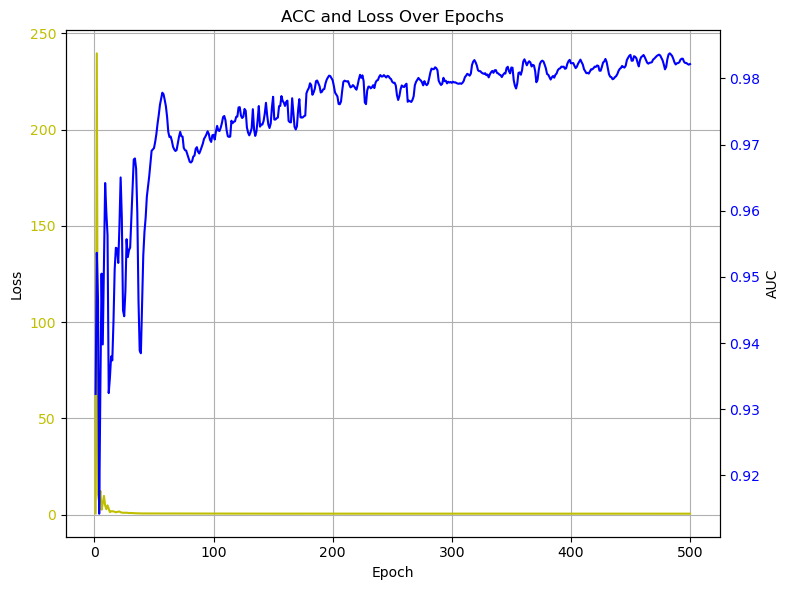

In [49]:
plot_auc_and_loss(loss_val,auc)
plot_acc_and_loss(loss_val,acc)